In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pickle
import json
import h5py

# on my system os error often pops up
# try to open the file explorer and copy paste the path again 
f = h5py.File("/media/dev/New Volume1/projects/DS LITE/static_dataset_lite.hdf5", "r")
cuda = torch.device('cuda')
frame_size = 10

In [6]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

# https://github.com/LiyuanLucasLiu/RAdam

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [7]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-1):
        super(Actor, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        # state = self.state_rep(state)
        x = F.relu(self.linear1(state))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x

In [8]:
class Critic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-5):
        super(Critic, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

In [9]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [10]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='monokai')

def run_tests():
    test_batch = [f[key][n_batches-1*batch_size:(n_batches)*batch_size] for key in
                 ['state', 'action', 'reward', 'next_state', 'done']]
    test_batch = prepare_batch(*test_batch)
    losses = ddpg_update(test_batch, debug=True, learn=False)
    return losses
    

# value, policy, step
def plot(value_losses, policy_losses, test=True, cfg=False):
    global test_losses
    if test:
        test_ = run_tests()
        test_losses[0].append(test_[0])
        test_losses[1].append(test_[1])
        test_losses[2].append(len(value_losses))
        
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('value')
    plt.plot(value_losses, label='train')
    plt.plot(test_losses[2], test_losses[0], label='test')
    plt.legend()
    plt.subplot(132)
    plt.title('policy')
    plt.plot(policy_losses, label='train')
    plt.plot(test_losses[2], test_losses[1], '-r', label='test')
    plt.legend()
    if cfg:
        plt.suptitle(cfg)
        
    plt.show()

In [11]:
from scipy.spatial import distance

def embed_show(embs):
    embs = embs.detach().cpu().numpy()
    similarity_matrix_cos = distance.cdist(embs, embs, 'cosine')
    similarity_matrix_euc = distance.cdist(embs, embs, 'euclidean')

    fig = plt.figure(figsize=(16,10))

    ax = fig.add_subplot(121)
    cax = ax.matshow(similarity_matrix_cos)
    fig.colorbar(cax)
    ax.set_title('Cosine')

    ax = fig.add_subplot(122)
    cax = ax.matshow(similarity_matrix_euc)
    fig.colorbar(cax)
    ax.set_title('Euclidian')

    fig.suptitle('Action pairwise distances')
    fig.show()

In [12]:
def debug_log_error(name, x):
    global debug_dict
    try:
        target = debug_dict['error'][name] 
    except KeyError:
        if name not in debug_dict['error']:
            debug_dict['error'][name] = {}
            target = debug_dict['error'][name] 
            target['std'] = []
            target['mean'] = []
    
    target['std'].append(x.std().item())
    target['mean'].append(x.mean().item())

def ddpg_update(batch, gamma = 0.9, min_value=-np.inf, max_value=np.inf,
           soft_tau=1e-4, debug=False, learn=True, step=-1):
    
    state, action, reward, next_state, done = batch
    
    if not learn:
        [net.eval() for net in nets]
    
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    
    
    gen_action = policy_net(state)
    policy_loss = -value_net(state, gen_action).mean()
    
    next_action = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    debug_log_error('target_value ', target_value)
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    debug_log_error('value', value)
    value_loss = torch.pow(value - expected_value.detach(), 2).mean()
    
    if debug:
        global debug_state
        global debug_action
        global debug_gen_action
        global debug_test_gen_action
        debug_state = state
        debug_action = action 
        if not learn:
            debug_test_gen_action = gen_action
        else:
            debug_gen_action = gen_action

    if not learn:
        # used for testing
        [net.train() for net in nets]
        losses = [value_loss.item(), policy_loss.item()]
        return losses
    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
    
    if step > 0 and step % P_policy_step == 0:
        policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), -1, 1)
        policy_optimizer.step()
        
        soft_update(value_net, target_value_net, soft_tau=P_soft_tau)
        soft_update(policy_net, target_policy_net, soft_tau=P_soft_tau)


    losses = [value_loss.item(), policy_loss.item()]
    
    return losses

In [13]:
# === ddpg settings ===
P_gamma = 0.99
P_min_value=-10
P_max_value=10
P_soft_tau=0.1
P_policy_lr = 1e-5
P_value_lr  = 1e-5
P_milestones = [1800]
P_policy_step = 3

P_cfg = {'gamma': P_gamma, 'min_v': P_min_value, 'max_v':P_max_value,
        'stau': P_soft_tau, 'policy_lr': P_policy_lr, 'value_lr': P_value_lr}
# === end ===

In [14]:
value_net  = Critic(256, 128, 320).to(cuda)
policy_net = Actor(256, 128, 192).to(cuda)

#value_net.load_state_dict(torch.load('../models/ddpg_sm_value.pt'))
#policy_net.load_state_dict(torch.load('../models/ddpg_sm_policy.pt'))

target_value_net = Critic(256, 128, 320).to(cuda)
target_policy_net = Actor(256, 128, 192).to(cuda)
target_policy_net.eval()
target_value_net.eval()

nets =[value_net, policy_net]

soft_update(value_net, target_value_net, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)

value_criterion = nn.MSELoss()

value_optimizer = optim.Adam(value_net.parameters(), lr=P_policy_lr, weight_decay=1e-2)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=P_value_lr, weight_decay=1e-2)

value_scheduler = optim.lr_scheduler.MultiStepLR(value_optimizer,  milestones=P_milestones)
#policy_scheduler = optim.lr_scheduler.MultiStepLR(policy_optimizer, milestones=P_milestones)

# todo unify
debug_state = None
debug_action = None
debug_gen_action = None
debug_test_gen_action = None
debug_target_value = []

debug_dict = {'error': {}}

In [ ]:
value_losses = []
policy_losses = []
test_losses = [[], [], []]

step = 1

n_epochs = 100
batch_size = 5000
n_batches = (f['state'].shape[0] // batch_size)

batch_bar = tqdm(total=n_batches)
epoch_bar = tqdm(total=n_epochs)

step 1440


/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


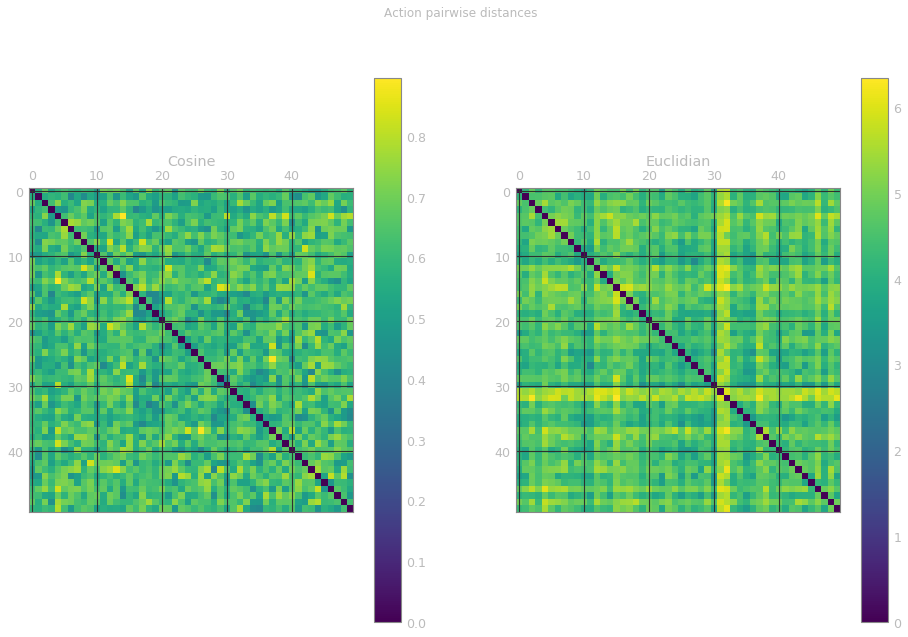

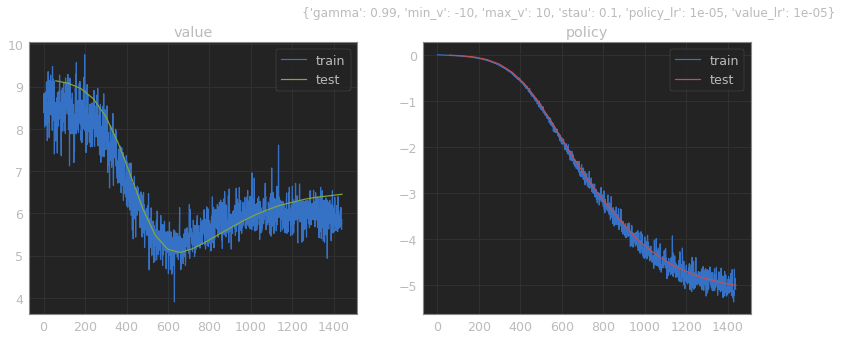

In [ ]:
def prepare_batch(*args):
    args = [torch.tensor(np.array(arg).astype(np.float)).to(cuda).float() for arg in args]
    return args

# --- config ---
DEBUG = True

batch = []
plot_every = 60
min_policy_state_dict = None
min_policy_loss = 1
# --- end ---

for epoch in range(n_epochs):
    epoch_bar.update(1)
    for i in range(n_batches-1):
        step += 1
        batch_bar.update(1)
        
        batch = [f[key][i*batch_size:(i+1)*batch_size] for key in
                 ['state', 'action', 'reward', 'next_state', 'done']]
        batch = prepare_batch(*batch)
        loss = ddpg_update(batch, debug=DEBUG, gamma = P_gamma, min_value=P_min_value,
                           max_value=P_max_value, soft_tau=P_soft_tau, step=step)
        
        value_losses.append(loss[0])
        policy_losses.append(loss[1])
        
        #if loss[1] < min_policy_loss and step > 1000:
            # note doen't change the target network
            #min_policy_loss = loss[1] 
            #min_policy_state_dict = policy_net.state_dict()
            
        #if step in P_milestones:
            #policy_net.load_state_dict(min_policy_state_dict)
            
        
        value_scheduler.step()
        # policy_scheduler.step()
        
        batch = []
        
        # debug plotting
        if step % plot_every == 0:
            clear_output(True)
            
            print('step', step)
            #if debug_test_gen_action is not None:
            #    embed_show(debug_test_gen_action[:50])
            embed_show(debug_gen_action[:50])
            plot(value_losses, policy_losses, cfg=P_cfg)
            
    batch_bar.refresh()

In [3]:
for key, error in debug_dict['error'].items():
    sf = int(np.sqrt(len(error['mean'])))
    plt.errorbar(range(len(error['mean'][::sf])), error['mean'][::sf], error['std'][::sf])
    plt.title(key)
    plt.show()

NameError: name 'debug_dict' is not defined

In [87]:
(torch.randn(10) * 5).var()

tensor(29.0513)

In [88]:
debug_gen_action[3]

tensor([-0.1066,  0.1027, -0.1313,  0.2007, -0.0747, -1.0740, -0.0934, -0.0923,
        -0.0179,  0.4118,  0.0601,  0.1888,  0.0809, -0.6478, -0.2031, -0.6202,
         0.0611, -0.3654,  0.5081, -0.1022, -0.3904,  0.7082, -0.4605, -0.3006,
         0.3411, -0.4941, -0.4820, -0.4109,  0.1104, -0.4456,  0.4629,  0.3679,
         0.0367,  0.0631, -0.0446, -0.0859, -0.0616, -0.1443, -0.1528, -0.1874,
        -0.0828, -0.2025, -0.3662, -0.2553, -0.2103,  0.7009, -0.1853, -0.2206,
         0.1996,  0.7639, -0.8701,  0.3368,  0.1501,  0.2032, -0.2573, -0.8251,
        -0.5886,  0.0782, -0.2108,  0.4976, -1.1669,  0.0825,  0.8004,  0.2605,
         0.3668, -0.6244, -0.0913,  0.3167, -0.3258, -0.0985,  0.0032,  0.0284,
        -0.3358,  0.3235,  0.8915,  0.1247,  0.0758,  0.6224, -0.7452, -0.1166,
        -0.0921, -0.0882, -0.1894, -0.4978,  0.3131, -0.2725, -0.4022, -0.1870,
         0.4892,  0.4417,  0.6511, -0.1285, -0.6871,  0.2234, -0.8517, -0.2721,
        -0.2151,  0.7498, -0.4361,  0.19

In [14]:
policy_net.load_state_dict(min_policy_state_dict)

In [16]:
# embed_show(debug_test_gen_action[:100])

In [63]:
debug_gen_action[1]

tensor([ 1.8877, -4.8584,  1.4720, -9.9517,  3.3914,  1.7307, -8.6627,  1.5801,
        -2.4214, -3.4602, -1.9452, -0.5645, -5.9886,  0.8119,  2.7078,  0.8723,
        -5.0976,  2.5018, -0.2652, -2.0179,  0.4973, -1.2914,  5.9566,  1.9010,
         1.0631, -0.1238,  5.2389,  5.7477,  2.3963,  2.9715, -6.7507, -3.7803,
        -1.6158, -1.0886, -4.3423,  2.7857, -4.6495,  3.1071,  3.2592, -7.9656,
         1.3436, -0.4634,  0.8722, -4.5353, -0.8097, -2.2001, -9.8565,  1.2997,
        -2.4568, -1.4565, -2.0886, -0.6113, -4.9303,  6.2661, -2.1249,  5.1005,
         5.6681, -2.8048,  1.4702, -3.8588,  5.6562,  0.7287, -5.6007,  1.5234,
        -3.1191, -0.8354,  5.0904,  0.2355,  1.8618,  2.6911,  2.0445,  1.0914,
         1.1966,  2.8150,  2.4542,  9.1654, -0.7617,  0.4757,  2.7009,  0.9720,
         2.6324,  5.9970,  1.8243,  2.2680,  1.7330, -2.0818, -2.5818,  3.9423,
        -0.3113, -7.1869,  5.9093, -1.0127, -6.3946,  1.1498,  2.5282, -5.4293,
         1.5795, -0.1438,  1.4024,  4.77

In [24]:
torch.save(value_net.state_dict(), "../models/ddpg_sm_value.pt")
torch.save(policy_net.state_dict(), "../models/ddpg_sm_policy.pt")

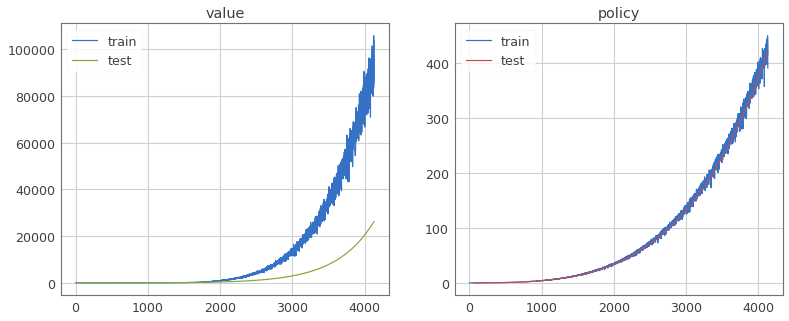

In [28]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3')
plot(value_losses, policy_losses)

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


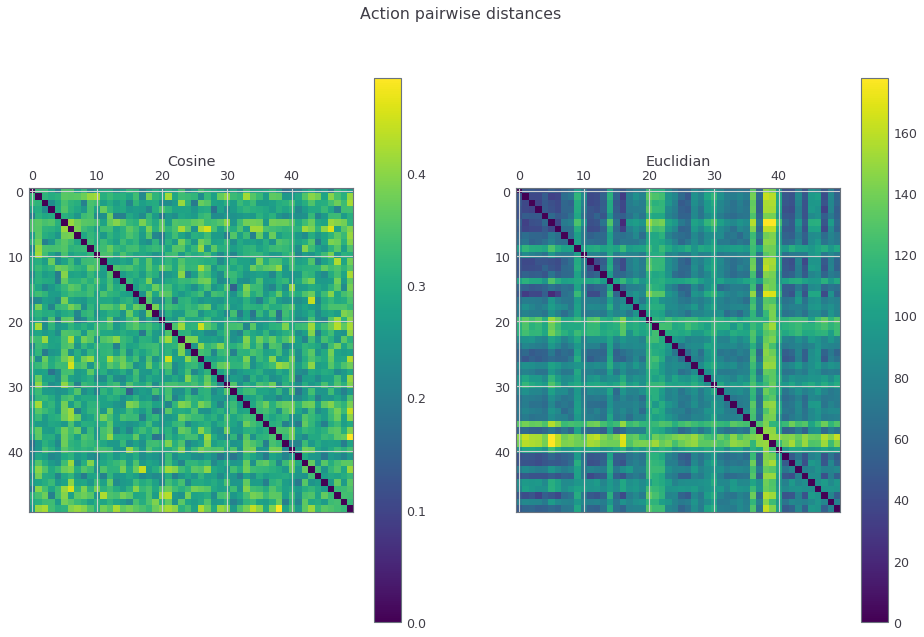

In [66]:
embed_show(debug_gen_action[:50])

# Test

In [67]:
import pickle 
from scipy.spatial import distance
movies = pickle.load(open('../data/infos_pca128.pytorch', 'rb'))
true_actions = np.stack([movies[i] for i in movies])
infos_web = json.load(open('../data/infos.json'))

# action is set here!

debug_gen_actions = debug_gen_action
debug_gen_action = debug_gen_actions[1632].detach().cpu().numpy()

genres_dict = {'Animation': 16,
 'Comedy': 35,
 'Family': 10751,
 'Adventure': 12,
 'Fantasy': 14,
 'Romance': 10749,
 'Drama': 18,
 'Action': 28,
 'Crime': 80,
 'Thriller': 53,
 'Horror': 27,
 'History': 36,
 'Science Fiction': 878,
 'Mystery': 9648,
 'War': 10752,
 'Music': 10402,
 'Documentary': 99,
 'Western': 37,
 'TV Movie': 10770,
 'Sport': 1,
 'Sci-Fi': 878,
 'Musical': 10402,
 'Short': 2,
 'News': 3,
 'Film-Noir': 4}
genres_dict = {v: k for k, v in genres_dict.items()}

In [68]:
scores = []
for i in movies.keys():
    scores.append([i, distance.euclidean(movies[i], debug_gen_action)])
scores = list(sorted(scores, key = lambda x: x[1]))

scores = scores[:10]
ids = [i[0] for i in scores]
for i in range(10):
    scores[i].extend([infos_web[str(scores[i][0])][key]  for key in ['title',
                            'genres', 'original_language', 'release_year', 'vote_average']])
    scores[i][3] = ' '.join([genres_dict[i] for i in scores[i][3]])
    
indexes = ['id', 'score', 'title', 'genres', 'language', 'year', 'rating']
table_dict = dict([(key,[i[idx] for i in scores]) for idx, key in enumerate(indexes)])
table = pd.DataFrame(table_dict)

In [69]:
table

,id,score,title,genres,language,year,rating
0,54378,34.088673,Man's Job,Drama,fi,2007,6.8
1,113378,34.113766,The Giver,Drama Sci-Fi,en,2014,6.5
2,76738,34.119362,Steam of Life,Documentary,fi,2010,7.4
3,109697,34.297260,Inspector Palmu's Error,Mystery Comedy Crime,fi,1960,7.0
4,102858,34.378021,My Stuff,Documentary,fi,2013,6.7
5,48043,34.407646,The Fountain,Drama Adventure Sci-Fi Romance,en,2006,6.9
6,43391,34.412067,Matti: Hell Is for Heroes,Comedy Drama,fi,2006,5.3
7,96316,34.455482,Aliisa,Drama TV Movie,fi,1970,0.0
8,99395,34.468254,A Time of Roses,Sci-Fi,en,1969,5.0
9,115721,34.530575,They Have Escaped,Drama,fi,2014,6.4


/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


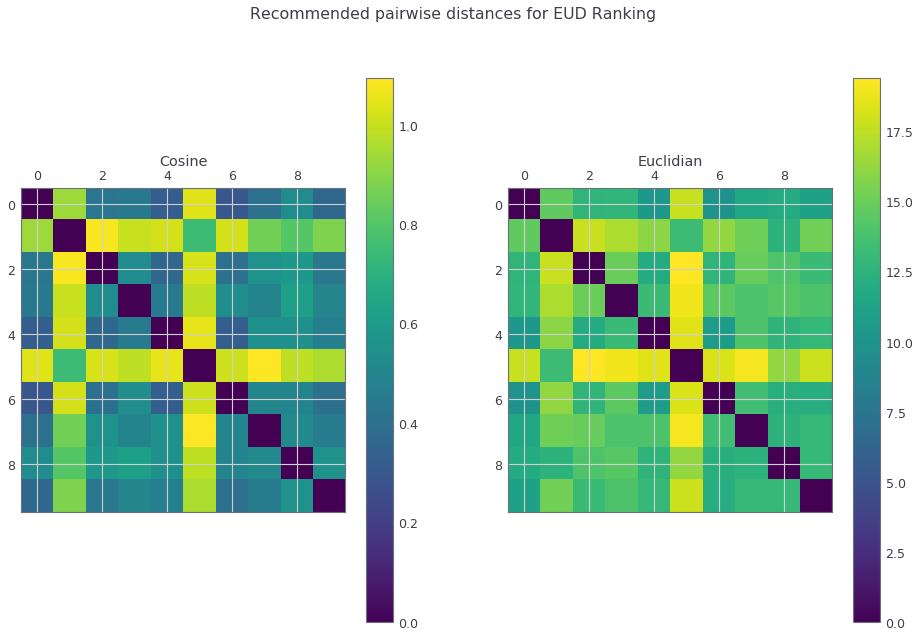

In [70]:
embs = np.stack([movies[i].numpy() for i in ids])
similarity_matrix_cos = distance.cdist(embs, embs, 'cosine')
similarity_matrix_euc = distance.cdist(embs, embs, 'euclidean')

fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(121)
cax = ax.matshow(similarity_matrix_cos)
fig.colorbar(cax)
ax.set_title('Cosine')

ax = fig.add_subplot(122)
cax = ax.matshow(similarity_matrix_euc)
fig.colorbar(cax)
ax.set_title('Euclidian')


fig.suptitle('Recommended pairwise distances for EUD Ranking')
fig.show()

In [71]:
scores = []
for i in movies.keys():
    scores.append([i, distance.cosine(movies[i], debug_gen_action)])
scores = list(sorted(scores, key = lambda x: x[1]))
scores = scores[:10]
ids = [i[0] for i in scores]
for i in range(10):
    scores[i].extend([infos_web[str(scores[i][0])][key]  for key in ['title',
                            'genres', 'original_language', 'release_year', 'vote_average']])
    scores[i][3] = ' '.join([genres_dict[i] for i in scores[i][3]])
    
indexes = ['id', 'score', 'title', 'genres', 'language', 'year', 'rating']
table_dict = dict([(key,[i[idx] for i in scores]) for idx, key in enumerate(indexes)])
table = pd.DataFrame(table_dict)

In [72]:
table

,id,score,title,genres,language,year,rating
0,113378,0.659181,The Giver,Drama Sci-Fi,en,2014,6.5
1,76738,0.665286,Steam of Life,Documentary,fi,2010,7.4
2,54378,0.670174,Man's Job,Drama,fi,2007,6.8
3,109697,0.677555,Inspector Palmu's Error,Mystery Comedy Crime,fi,1960,7.0
4,102858,0.689682,My Stuff,Documentary,fi,2013,6.7
5,43391,0.690928,Matti: Hell Is for Heroes,Comedy Drama,fi,2006,5.3
6,108752,0.693622,Päämaja,Drama History War,fi,1970,7.0
7,96316,0.693649,Aliisa,Drama TV Movie,fi,1970,0.0
8,48043,0.694578,The Fountain,Drama Adventure Sci-Fi Romance,en,2006,6.9
9,92687,0.696436,The Boys,Drama War,fi,1962,7.0


/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


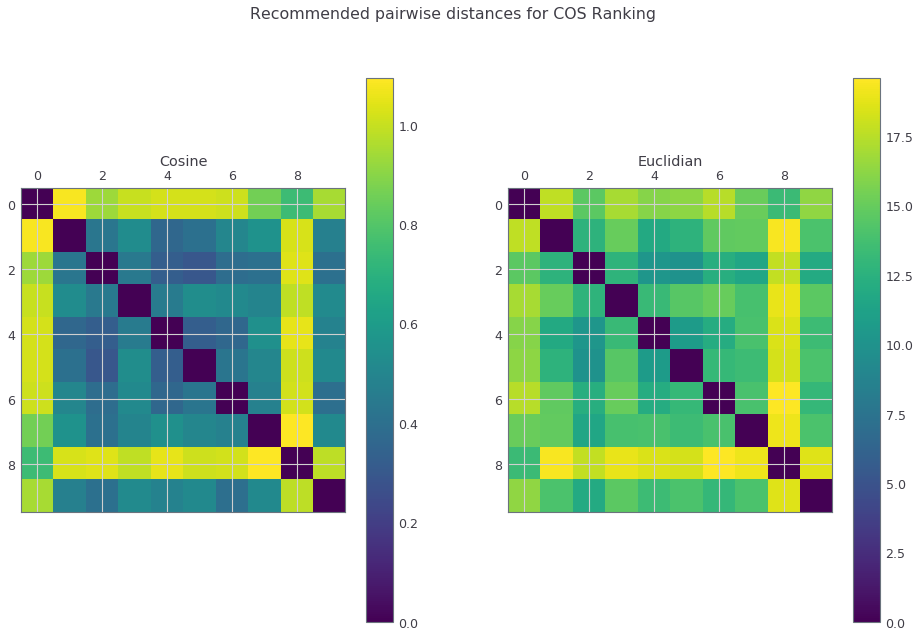

In [73]:
embs = np.stack([movies[i].numpy() for i in ids])
similarity_matrix_cos = distance.cdist(embs, embs, 'cosine')
similarity_matrix_euc = distance.cdist(embs, embs, 'euclidean')

fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(121)
cax = ax.matshow(similarity_matrix_cos)
fig.colorbar(cax)
ax.set_title('Cosine')

ax = fig.add_subplot(122)
cax = ax.matshow(similarity_matrix_euc)
fig.colorbar(cax)
ax.set_title('Euclidian')
fig.suptitle('Recommended pairwise distances for COS Ranking')
fig.show()